# STIPS Advanced II – PSFs, Adding Sources

This portion of the Advanced tutorial concerns the generation and manipulation of PSFs using STIPS functions.  As with Advanced I, this notebook assumes both that you already have STIPS installed (see [Installing STIPS](https://stsci-stips.readthedocs.io/en/latest/installation.html) if not) and that you are comfortable with basic usage of STIPS functionalities (see [STIPS Basic Tutorial](https://stips.readthedocs.io/en/latest/basic_tutorial.html), or the Basic Tutorial notebook, if not).

#### Note:
The ```makePSF``` package is still undergoing development –– pending the inclusion of logging functions and error catching, as well as some functional optimization.  This tutorial will be updated to reflect this in future releases.

## Checking STIPS Import, Adding Modules

Before beginning, check again that the STIPS import is correct, and import and configure a few modules we'll be needing.  Additionally, ensure that the generated files from the Basic Tutorial are visible in your "notebooks" folder/the directory from which you are working.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

from astropy.io import fits
from glob import glob
import numpy as np
import matplotlib
from matplotlib import style
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
matplotlib.rcParams['axes.grid'] = False
matplotlib.rcParams['image.origin'] = 'lower'
import stips

print(stips.__env__report__)

**WARNING**: LOCAL JWST PRD VERSION PRDOPSSOC-062 CANNOT BE CHECKED AGAINST ONLINE VERSION


STIPS Version 2.0.0 with Data Version 1.0.9 at /Users/sebastian/Documents/STIPS/stips_data.
	STIPS Grid Generated with 1.0.8
Pandeia Version 3.0 with Data Version 3.0 at /Users/sebastian/Documents/STIPS/pandeia_data-3.0_roman.
Webbpsf Version 1.1.1 with Data Version 1.1.1 at /Users/sebastian/Documents/STIPS/webbpsf-data.



In [2]:
file_list = glob('*notebook_example*')
print(file_list)

['notebook_example_1_0.fits']


## Generating and Manipulating a PSF

PSFs can be generated using FITS input files and the makePSF module within STIPS.  For this example, we will be using the example PSF file "psf_WFI_2.0.0_F129_sca01.fits", a PSF generated with Roman WFI F129.  This file is available in the "notebooks" directory of STIPS.  The generated PSF will be returned as an array.

In [3]:
example_file = fits.open('psf_WFI_2.0.0_F129_sca01.fits')

test_psf = stips.utilities.makePSF.make_epsf(example_file[0].data[0])

print(test_psf)

[[4.63340175e-09 4.92926905e-09 5.06057647e-09 ... 1.04694074e-08
  9.75042028e-09 0.00000000e+00]
 [4.31357501e-09 4.60752880e-09 4.79127975e-09 ... 1.04253472e-08
  9.61258937e-09 0.00000000e+00]
 [3.99596581e-09 4.25482504e-09 4.52264410e-09 ... 1.02763533e-08
  9.45093424e-09 0.00000000e+00]
 ...
 [5.29699428e-09 5.36962514e-09 5.49581773e-09 ... 6.47929589e-09
  5.97876614e-09 0.00000000e+00]
 [4.70650252e-09 4.79887355e-09 4.91860814e-09 ... 6.71186040e-09
  6.11143555e-09 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]


We can view a plot of our generated PSF using pyplot.

<Figure size 640x480 with 0 Axes>

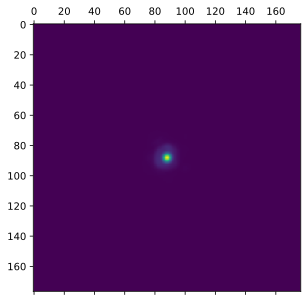

In [4]:
fig1 = plt.figure()
im1 = plt.matshow(test_psf)
plt.savefig('adv_notebook_epsf_orig.jpeg')

The PSF can be manipulated in a variety of ways –– for purposes of this tutorial, we will perform a bicubic interpolation on our PSF, as well as calculate the fraction of light that should fall on a given pixel.  This will employ two of makePSFs primary functions, ```makePSF.bicubic``` and ```makePSF.real_psf```.

### Bicubic Interpolation

For our bicubic interpolation, we will use the following input parameters, selecting a reference point close to the source in the hopes of seeing more engaging results:

* Reference x pixel (```ix```) – 85
* Reference y pixel (```iy```) – 85
* Pixel phase along the x-direction (```fx```) – 5
* Pixel phase along the y-direction (```fy```) – 5

In [5]:
ix = iy = 85
fx = fy = 5

stips.utilities.makePSF.bicubic(test_psf, iy, ix, fx, fy)

-3.867468290857751

Noted in the image below is the location at which the interpolation was performed (cropped for visibility).

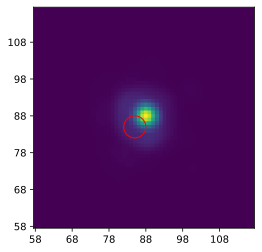

In [4]:
# Plot parameters
x_mid = 88
y_mid = 88
half = 30

# create custom formatter for cutout region axes (run once)
ticks_x = ticker.FuncFormatter(lambda x, pos: f"{x + x_mid - half:.0f}")
ticks_y = ticker.FuncFormatter(lambda y, pos: f"{y + y_mid - half:.0f}")

# to plot cutout region:
fig0, ax0 = plt.subplots(figsize=(4,4))
ax0.imshow(test_psf[x_mid - half:x_mid + half,
                    y_mid - half:y_mid + half])

# replace default tick labels with cutout pixel indices
# (run in every cell that shows a plot of the cutout region)
ax0.set_xticks([x for x in ax0.get_xticks() if 0 <= x < half*2])
ax0.xaxis.set_major_formatter(ticks_x)
ax0.yaxis.set_major_formatter(ticks_y)

#Coordinates of circle adjusted for crop.
circ_bicubic = plt.Circle((27, 27), 3, color='r', fill=False)

ax0.add_patch(circ_bicubic)

### Fractional Light

Using ```makePSF.real_psf```, we can caculate the fraction of light from our epsf that should fall on any given pixel.  We will use the following parameters:

* Relative location of source along x-axis (```dx```) (note that 0 the default the center of the boxsize) –– 5
* Relative location of the source along y-axis (```dy```) –– 5
* Center of the input psf model (```psf_center```) (our PSF has dimensions of 177 by 177 px) –– 88
* PSF boxsize (```boxsize```) –– 177

#### Note:

Currently, the default value of ```psf_center``` is set to 177, and default boxsize 44 –– this will be adjusted in future updates.

In [7]:
dx = dy = 5

#The code below is designed to modify the default values for the center
#and size of the PSF to fit the PSF being used –– this will be addressed
#in future releases.

psf_middle = round((test_psf[0].shape[0]-1)/2)

PSF_BOXSIZE = np.floor(psf_middle)/4

stips.utilities.makePSF.real_psf(dx, dy, test_psf, boxsize=PSF_BOXSIZE, psf_center=psf_middle)

0.00044947279766548826

Noted below is the location at which fractional light was evaluated.

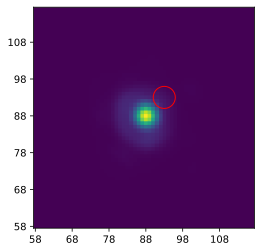

In [5]:
# to plot cutout region:
fig1_2, ax1_2 = plt.subplots(figsize=(4,4))
ax1_2.imshow(test_psf[x_mid - half:x_mid + half,
                    y_mid - half:y_mid + half])

# replace default tick labels with cutout pixel indices
# (run in every cell that shows a plot of the cutout region)
ax1_2.set_xticks([x for x in ax1_2.get_xticks() if 0 <= x < half*2])
ax1_2.xaxis.set_major_formatter(ticks_x)
ax1_2.yaxis.set_major_formatter(ticks_y)

#Coordinates of circle adjusted for crop.
circ_real_psf = plt.Circle((35, 35), 3, color='r', fill=False)

ax1_2.add_patch(circ_real_psf)

## Adding New Sources to a Scene

To add a new source to our generated scene from the Basic Tutorial, we will use the ```place_source``` function from ```makePSF``` and insert a source with the following characteristics:

* Location (px)
    * x = 2000
    * y = 2000
* Flux = 15

Note that, by default, the PSF upscale is 4.

#### Note:

Currently, the default value of ```psf_center``` is set to 177, and default boxsize 44 –– this will be adjusted in future updates.

### Original Scene

Re-open the original scene from the saved output file –– by default, this file is "notebook_example_1_0.fits".  We will limit our area of view to the range in which the added source will be visible, between 1950 and 2150 pixels on each axis.

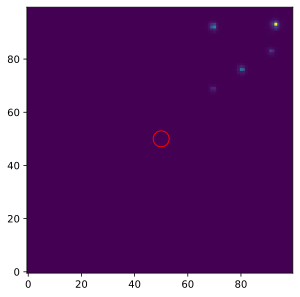

In [7]:
with fits.open('notebook_example_1_0.fits') as result_file:
    result_data = result_file[1].data

fig2, ax2 = plt.subplots()
ax2.imshow(result_data[1950:2050, 1950:2050])

circ_no_source = plt.Circle((50, 50), 3, color='r', fill=False)

ax2.add_patch(circ_no_source)

### Add New Source

We now use the ```makePSF.place_source``` function to add in our test PSF as a source (noting that the ```boxsize``` and ```psf_center``` parameters must be modified from their defaults for this particular PSF, as was the case with the ```makePSF.real_psf example```).

In [8]:
#The code below is designed to modify the default values for the center
#and size of the PSF to fit the PSF being used –– this will be addressed
#in future releases.

psf_middle = round((test_psf[0].shape[0]-1)/2)

PSF_BOXSIZE = np.floor(psf_middle)/4

added_source = stips.utilities.makePSF.place_source(2000, 2000, 3000, result_data, test_psf, boxsize=PSF_BOXSIZE, psf_center=psf_middle)

We can now open our modified image and view our added source.

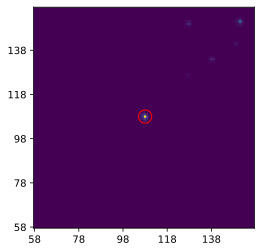

In [9]:
# Plot parameters
x_mid2 = 2000
y_mid2 = 2000
half2 = 50

# to plot cutout region:
fig2_1, ax2_1 = plt.subplots(figsize=(4,4))
ax2_1.imshow(result_data[x_mid2 - half2:x_mid2 + half2,
                    y_mid2 - half2:y_mid2 + half2])

# replace default tick labels with cutout pixel indices
# (run in every cell that shows a plot of the cutout region)
ax2_1.set_xticks([x for x in ax2_1.get_xticks() if 0 <= x < half2*2])
ax2_1.xaxis.set_major_formatter(ticks_x)
ax2_1.yaxis.set_major_formatter(ticks_y)

#Coordinates of circle adjusted for crop.
circ_source = plt.Circle((50, 50), 3, color='r', fill=False)

ax2_1.add_patch(circ_source)

## Conclusion

This concludes the second portion of the advanced tutorial.  If you have further questions, check out the [STIPS documentation](https://stips.readthedocs.io/en/latest/), or reach out to the STIPS Helpdesk via email at help@stsci.edu with the subject line "STIPS Question".